In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from gcpv import GCPVClusterer, GCPVMultilayerStorageDirectoryLoader, AllGuidesGCPVOptimizerMSCOCO, GCPVExperimentConstants
from gcpv import yolo5_propagator_builder, ssd_propagator_builder, efficientnet_propagator_builder, mobilenet_propagator_builder, draw_mscoco_categories_and_colors

%matplotlib inline

/home/ec2-user/workspace/venvs/gcpv_venv_no_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/ec2-user/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-6 Python-3.9.17 torch-1.13.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [2]:
# Select the network to optimize GCPVs for
net_tag = 'yolo'
clustering_settings = 'relaxed'
segmenter_tag = 'original'

# network builders caller
nets = {
    'yolo': yolo5_propagator_builder,
    'ssd': ssd_propagator_builder,
    'efficientnet': efficientnet_propagator_builder,
    'mobilenet': mobilenet_propagator_builder,
}

layers = {
    'yolo': ['10.conv', '17.cv3.conv', '20.cv3.conv'],
    'ssd': ['backbone.features.21', 'backbone.extra.0.5', 'backbone.extra.1.0'],
    'efficientnet': ['features.5.0', 'features.6.0', 'features.7.0'],                       
    'mobilenet': ['features.12', 'features.14', 'features.15'],
}

# load model & attach hooks to layers
# layers are already in *_builder functions, however, layers from the paper are used here to speed-up the overall computation
# you can specify your custom layers:
# propagator = nets[net_tag]([layer1, layer2, layer3, ...])
selected_layers = layers[net_tag]
propagator = nets[net_tag](selected_layers)

gcpv_optimizer_wrapper = AllGuidesGCPVOptimizerMSCOCO(propagator, net_tag)

# override to reduce the amount of optimized categories to speed-up the process
gcpv_optimizer_wrapper.mscoco_tags = {3: 'car', 4: 'motorcycle', 5: 'airplane', 17: 'cat', 19: 'horse', 22: 'elephant'}

# optimize for desired segmentations, options: 'original', 'rectangle', 'ellipse'
# or gcpv_optimizer_wrapper.run_optimization() for all segmenters
gcpv_optimizer_wrapper.run_optimization_one_segmenter(segmenter_tag)

Using cache found in /home/ec2-user/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-6 Python-3.9.17 torch-1.13.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


2024-04-10 22:55:45.327 INFO gcpv_optimizer.py.run_optimization_one_segmenter:328 Optimizing 'car' category
2024-04-10 22:55:45.328 INFO gcpv_optimizer.py.optimize_images:236 Optimizing 535 images
2024-04-10 22:57:51.298 INFO gcpv_optimizer.py.run_optimization_one_segmenter:328 Optimizing 'motorcycle' category
2024-04-10 22:57:51.299 INFO gcpv_optimizer.py.optimize_images:236 Optimizing 159 images
2024-04-10 22:58:59.242 INFO gcpv_optimizer.py.run_optimization_one_segmenter:328 Optimizing 'airplane' category
2024-04-10 22:58:59.243 INFO gcpv_optimizer.py.optimize_images:236 Optimizing 97 images
2024-04-10 22:59:42.917 INFO gcpv_optimizer.py.run_optimization_one_segmenter:328 Optimizing 'cat' category
2024-04-10 22:59:42.918 INFO gcpv_optimizer.py.optimize_images:236 Optimizing 184 images
2024-04-10 23:01:19.595 INFO gcpv_optimizer.py.run_optimization_one_segmenter:328 Optimizing 'horse' category
2024-04-10 23:01:19.597 INFO gcpv_optimizer.py.optimize_images:236 Optimizing 128 images
20

2024-04-10 23:03:13.877 INFO gcpv_clusterer.py.cluster_gcpvs:97 Clustering...
2024-04-10 23:03:13.944 INFO gcpv_clusterer.py._gcpv_cluster_infos:158 Cluster 0: P(motorcycle) = 0.03, P(cat) = 0.93, P(horse) = 0.04
2024-04-10 23:03:13.945 INFO gcpv_clusterer.py._gcpv_cluster_infos:158 Cluster 1: P(airplane) = 0.01, P(cat) = 0.01, P(horse) = 0.06, P(elephant) = 0.91
2024-04-10 23:03:13.945 INFO gcpv_clusterer.py._gcpv_cluster_infos:158 Cluster 2: P(motorcycle) = 0.04, P(airplane) = 0.02, P(horse) = 0.83, P(elephant) = 0.10
2024-04-10 23:03:13.946 INFO gcpv_clusterer.py._gcpv_cluster_infos:158 Cluster 3: P(car) = 0.02, P(motorcycle) = 0.06, P(airplane) = 0.91, P(horse) = 0.02
2024-04-10 23:03:13.947 INFO gcpv_clusterer.py._gcpv_cluster_infos:158 Cluster 4: P(car) = 0.97, P(motorcycle) = 0.03
2024-04-10 23:03:13.948 INFO gcpv_clusterer.py._gcpv_cluster_infos:158 Cluster 5: P(car) = 0.44, P(motorcycle) = 0.15, P(airplane) = 0.03, P(cat) = 0.18, P(elephant) = 0.21
2024-04-10 23:03:13.948 INFO

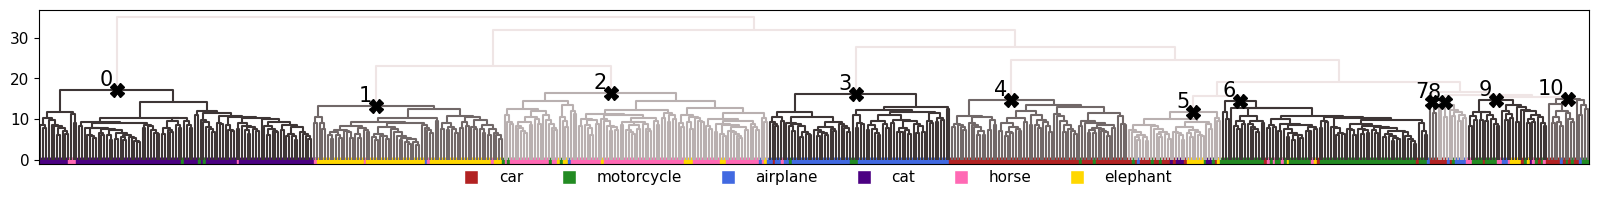

In [3]:
res_dir = os.path.join(gcpv_optimizer_wrapper.out_base_dir, f'gcpv_{segmenter_tag}_{net_tag}')
in_dir_imgs = gcpv_optimizer_wrapper.mscoco_imgs_path

gcpv_optimized_categories = list(gcpv_optimizer_wrapper.mscoco_tags.keys())

gcpv_loader = GCPVMultilayerStorageDirectoryLoader(res_dir, seed=0)
gcpv_storages = gcpv_loader.load(gcpv_optimized_categories)

selected_tag_id_names, selected_tag_ids_and_colors = draw_mscoco_categories_and_colors(gcpv_optimized_categories)   

n_samples_per_tag = GCPVExperimentConstants.N_SAMPLES_PER_TAG
distance = GCPVExperimentConstants.DISTANCE
method = GCPVExperimentConstants.METHOD
categories = GCPVExperimentConstants.MSCOCO_CATEGORIES

cluster_purity = GCPVExperimentConstants.PURITY[clustering_settings]
sample_threshold_coefficient = GCPVExperimentConstants.SAMPLE_THRESHOLD_COEFFICIENT[clustering_settings]
cluster_size = int(sum([len(l) for l in gcpv_storages.values()]) * sample_threshold_coefficient)

gcpv_clusterer = GCPVClusterer(selected_tag_ids_and_colors, selected_tag_id_names, selected_layers, n_samples_per_tag, cluster_size, cluster_purity, distance, method)

_ = gcpv_clusterer.cluster_gcpvs(gcpv_storages)

gcpv_clusterer.gcpv_dendogram(gcpv_storages)

2024-04-10 23:03:20.114 INFO gcpv_clusterer.py.gcpv_cluster_projection:829 Evaluating cluster projections...


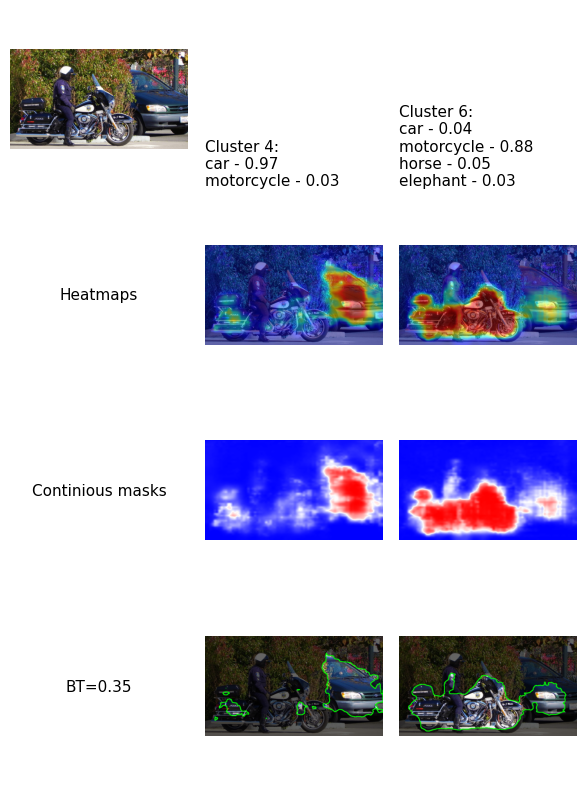

2024-04-10 23:03:21.361 INFO gcpv_clusterer.py.gcpv_cluster_projection:829 Evaluating cluster projections...


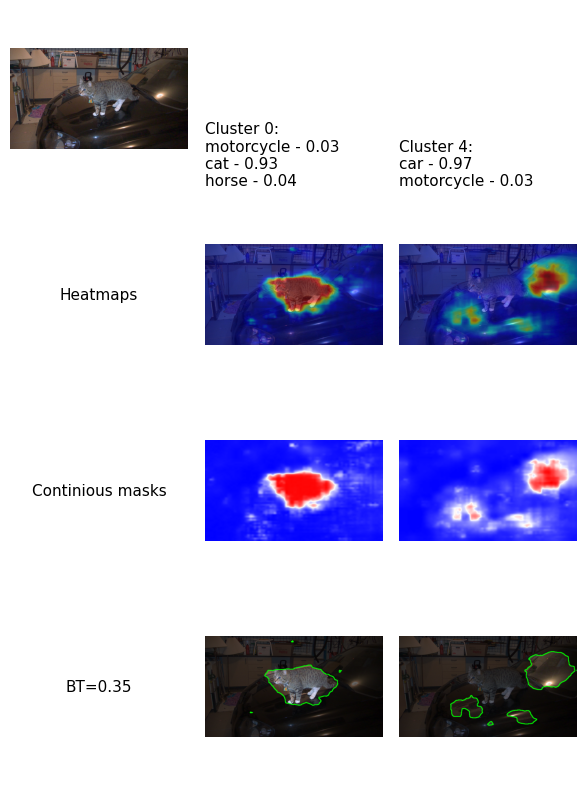

2024-04-10 23:03:22.492 INFO gcpv_clusterer.py.gcpv_cluster_projection:829 Evaluating cluster projections...


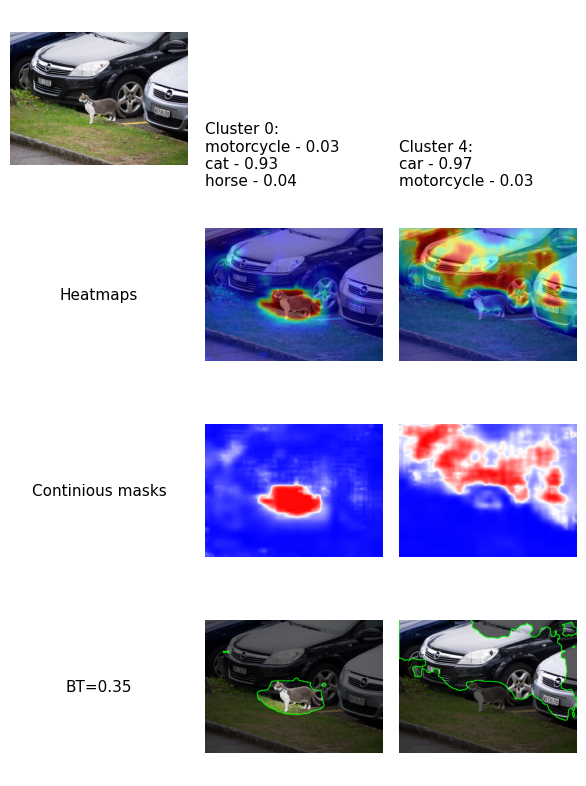

2024-04-10 23:03:23.788 INFO gcpv_clusterer.py.gcpv_cluster_projection:829 Evaluating cluster projections...


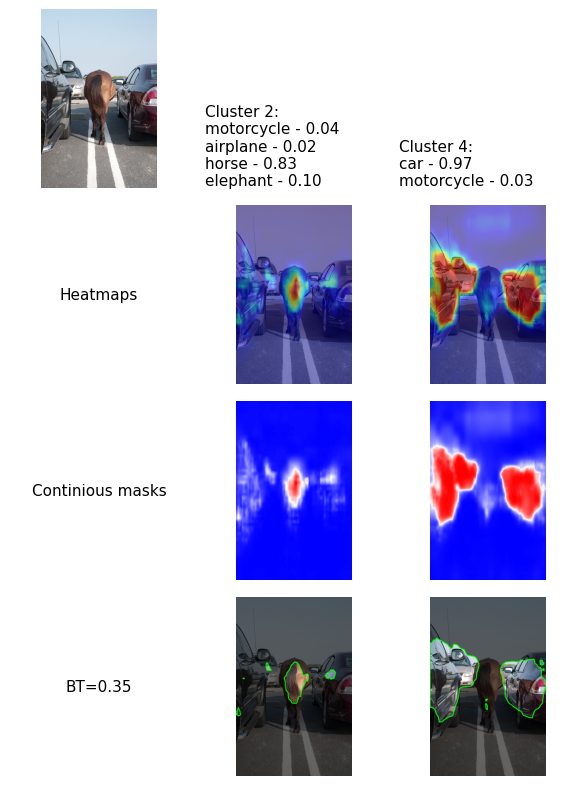

In [4]:
# provide cluster IDs (with dominant label of respected color)
car_cluster_id = 4
cat_cluster_id = 0
horse_cluster_id = 2
motorcycle_cluster_id = 6

# Weak concept localization
gcpv_clusterer.gcpv_cluster_projection(propagator, in_dir_imgs, '000000230008.jpg', sorted([car_cluster_id, motorcycle_cluster_id]), [0.35])  # car, motorcycle
gcpv_clusterer.gcpv_cluster_projection(propagator, in_dir_imgs, '000000010363.jpg', sorted([car_cluster_id, cat_cluster_id]), [0.35])  # cat, car
gcpv_clusterer.gcpv_cluster_projection(propagator, in_dir_imgs, '000000172330.jpg', sorted([car_cluster_id, cat_cluster_id]), [0.35])  # cat, car
gcpv_clusterer.gcpv_cluster_projection(propagator, in_dir_imgs, '000000368335.jpg', sorted([car_cluster_id, horse_cluster_id]), [0.35])  # car, horse

In [5]:
#predictions = gcpv_clusterer.predict_gcpvs_with_centroids(gcpv_storages_test)
#predictions = gcpv_clusterer.predict_gcpvs_with_knn(gcpv_storages_test)

cluster_0.jpg


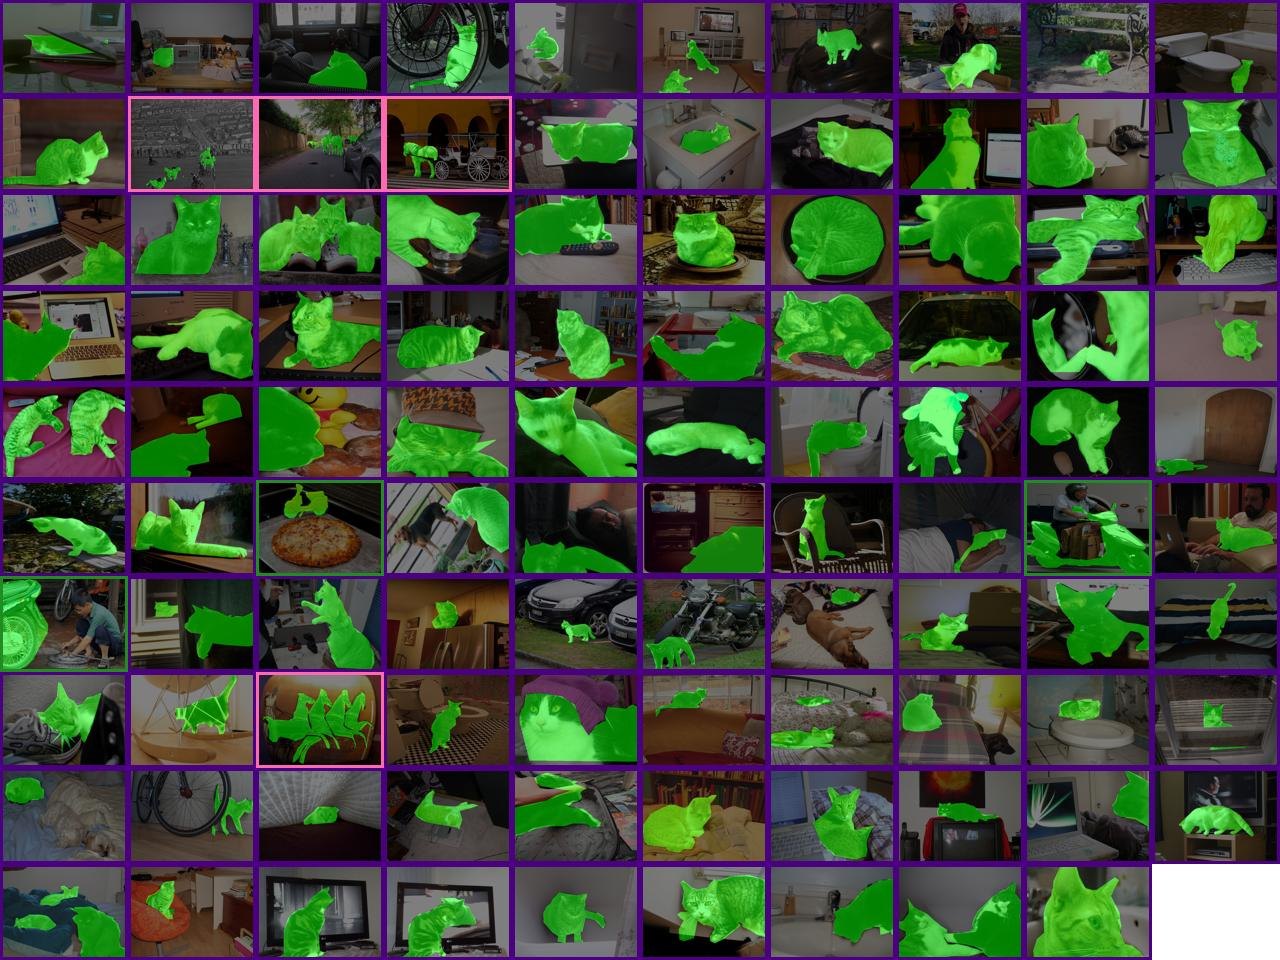

cluster_1.jpg


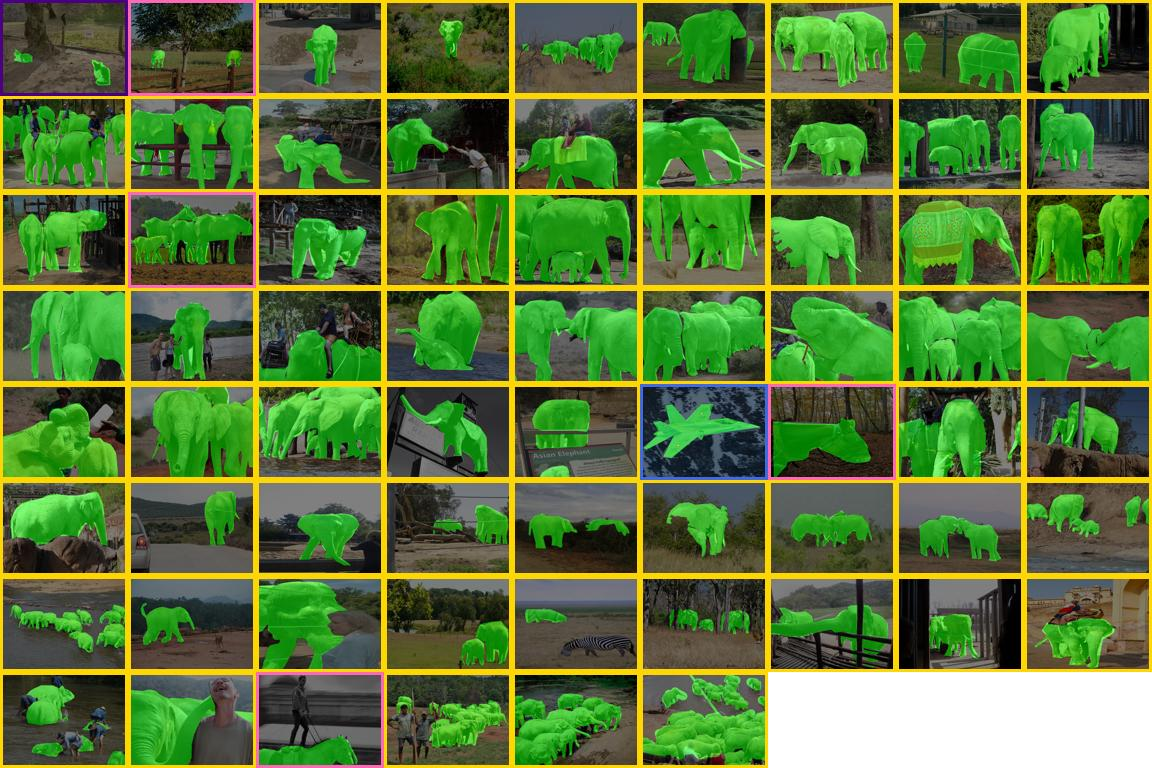

cluster_2.jpg


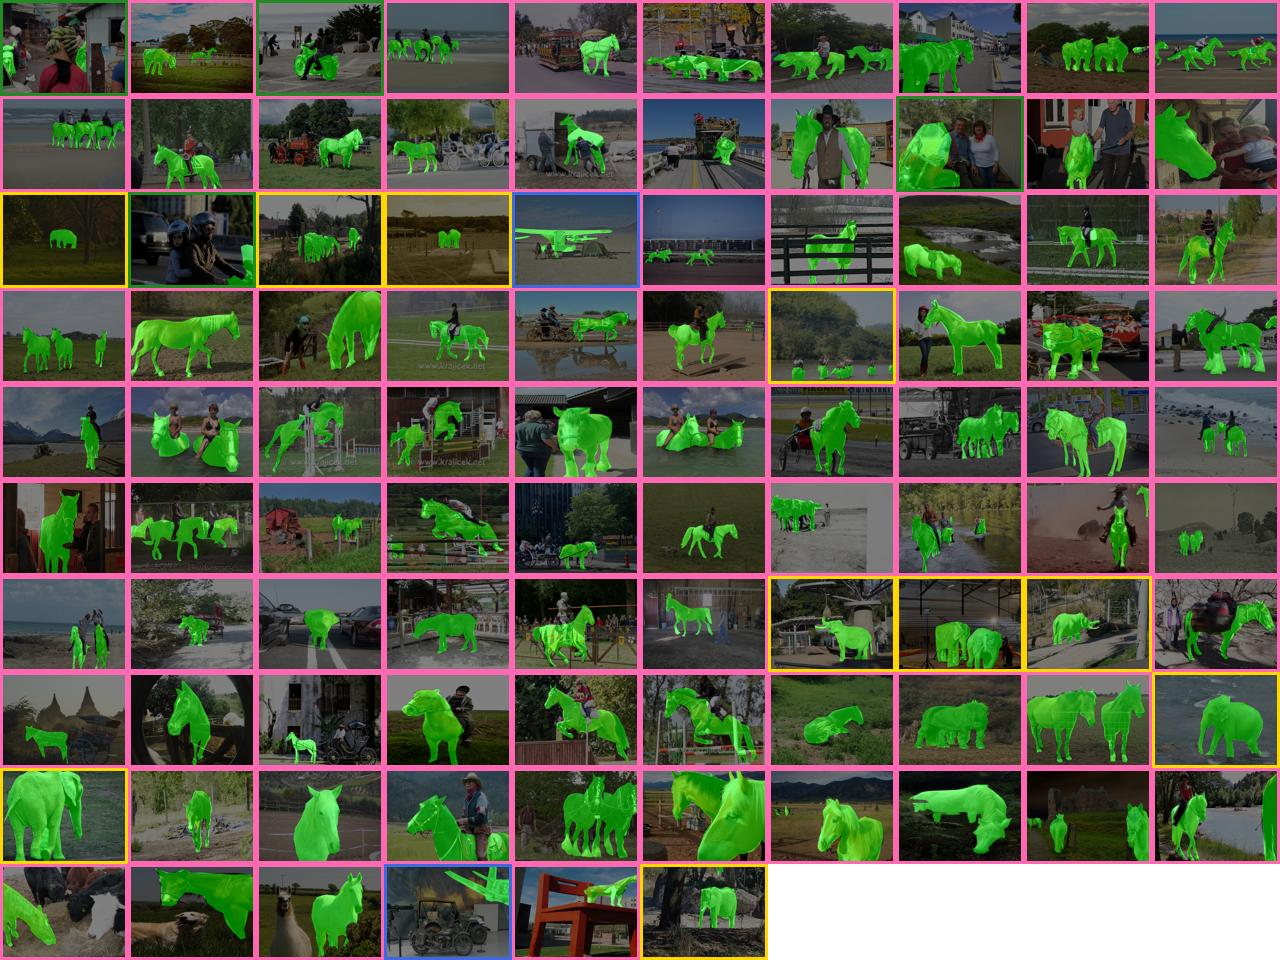

cluster_3.jpg


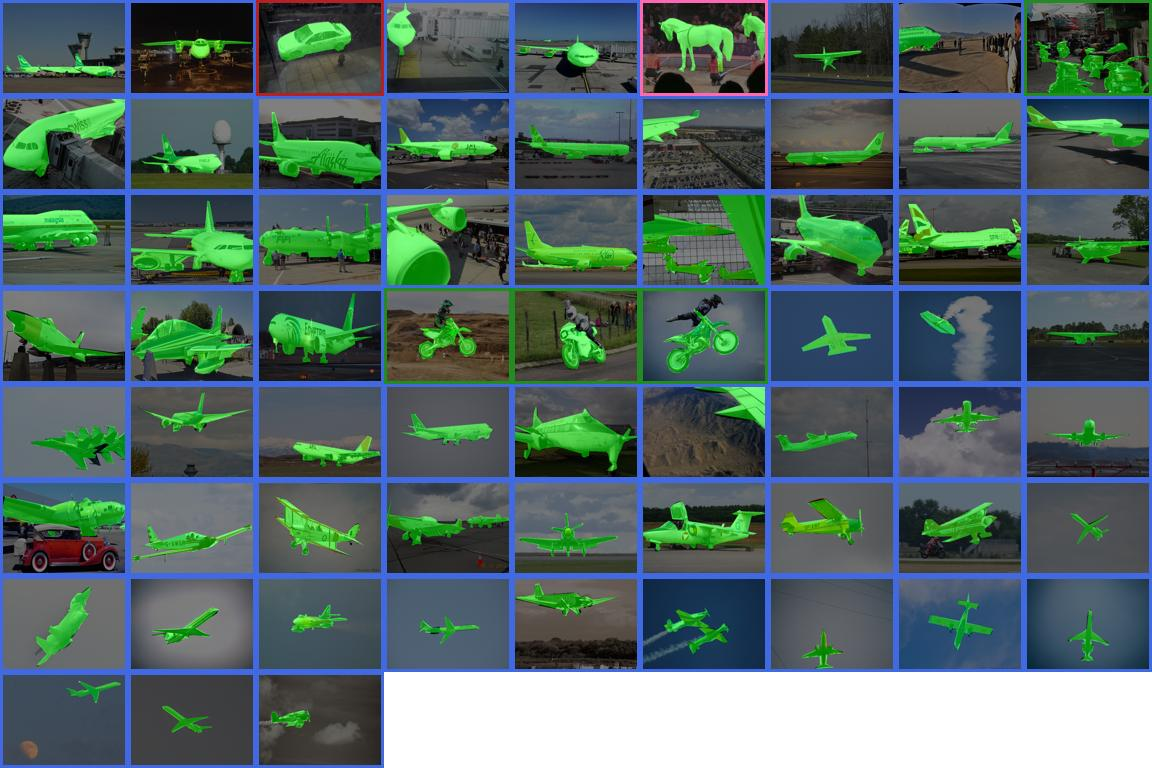

cluster_4.jpg


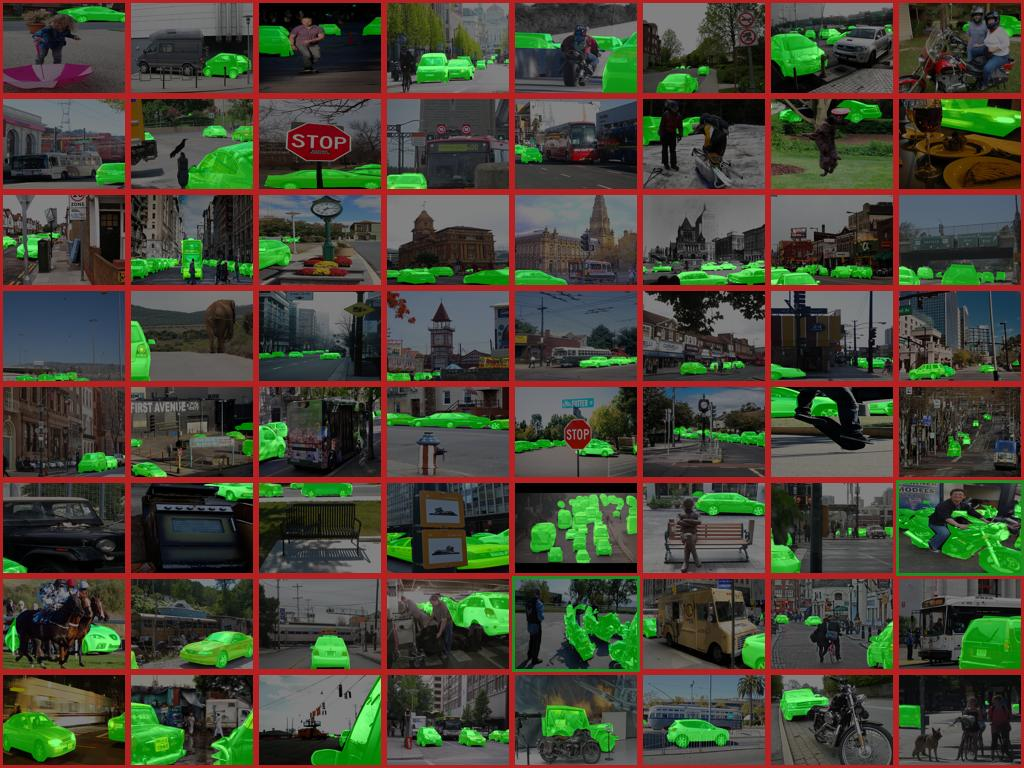

cluster_5.jpg


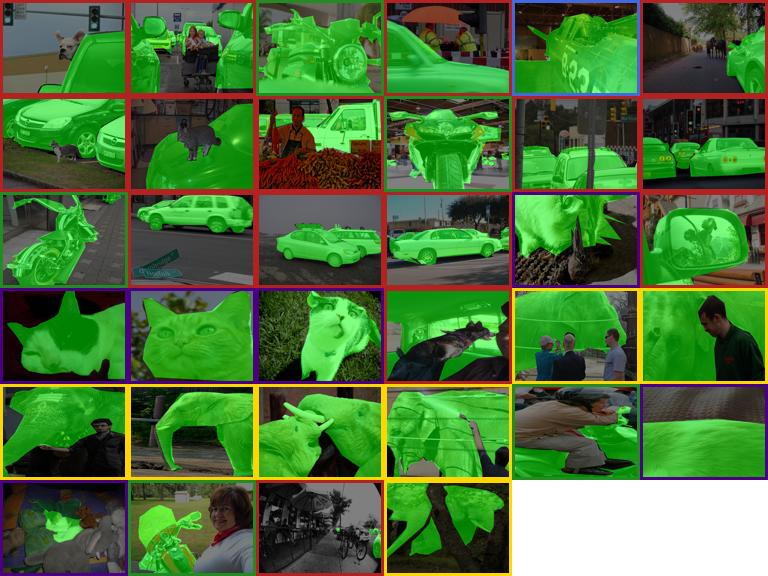

cluster_6.jpg


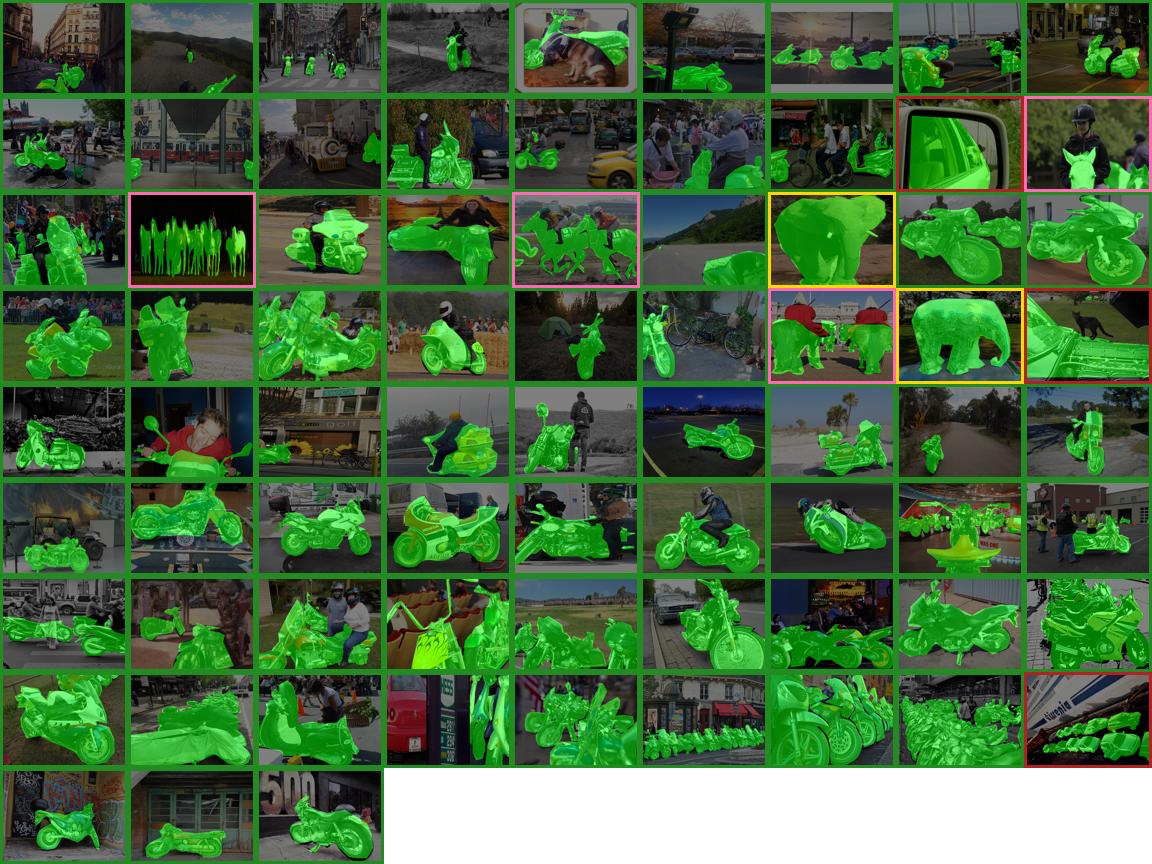

cluster_7.jpg


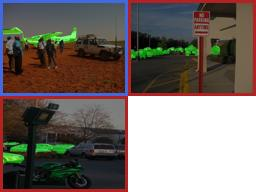

cluster_8.jpg


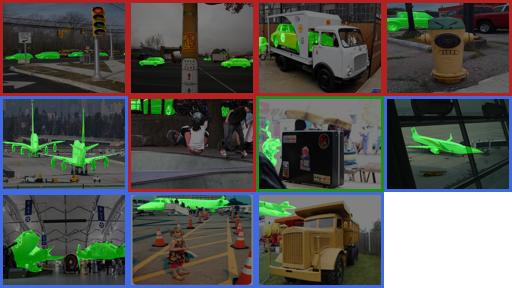

cluster_9.jpg


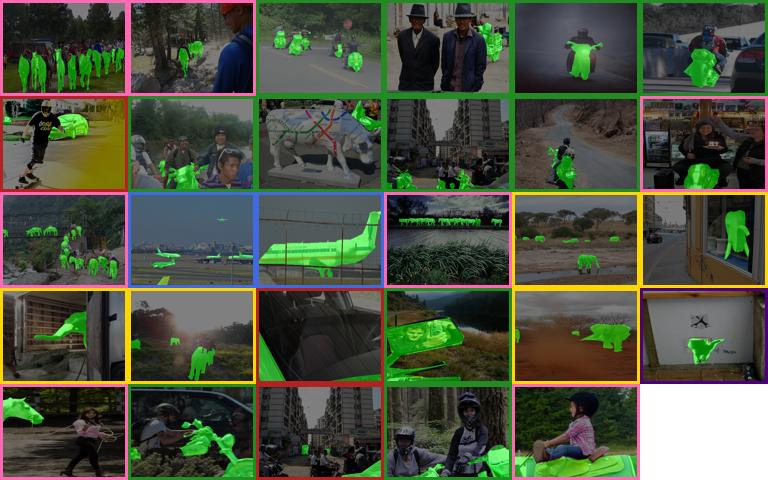

cluster_10.jpg


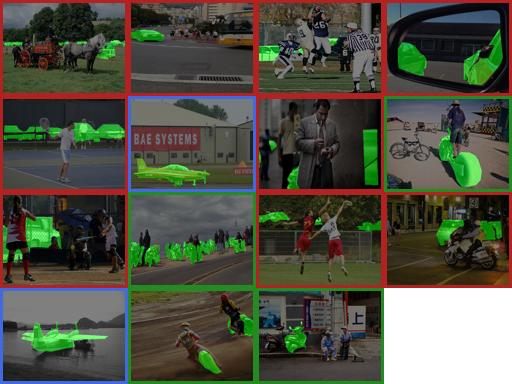

In [6]:
import os
from IPython.display import display, Image

folder_path = "./experiment_outputs/gcpv_clustering/gcpv_clustered_imgs_tiles"

# List all files in the folder
file_list = os.listdir(folder_path)

# Display each image
for file_name in file_list:
    print(file_name)
    file_path = os.path.join(folder_path, file_name)
    display(Image(filename=file_path))